# Chapter 8 Tree-Based Methods Exercises

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pydot
from IPython.display import Image
from io import StringIO
import os

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler

from src import ch8_utils

%matplotlib inline

### 8.2. Why is boosting using depth-one trees (or stumps) analogous to an additive model?

An additive model is one in which each variable is applied its own formula. "Stumped Boosting" more or less performs the same exercise by splitting one feature for each tree.


### 8.5. Ten bootstrapped samples question.

If I use the **majority-vote approach**, the predicted classification is **red**. If I apply **average probability**, the predicted classification is **green**.

In [2]:
q5_arr = np.array([0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75])
q5_arr.mean()

0.45

### 8.5. A detailed explanation of the algorithm that is used to fit a regression tree.

- 

## Conceptual

### 8.7. Create a plot displaying the test error resulting from a random forest on the Boston dataset for a more comprehensive range of values for "max_features" and "n_estimators."

In [3]:
url_path = os.path.abspath('..')
boston = pd.read_csv(url_path + '/data/Boston.csv')

X = boston.drop('medv', axis=1)
y = boston['medv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [4]:
num_trees = np.arange(1, 502, 50)
num_features = np.arange(2, X_train.shape[1], 2)
rf_mse_df = pd.DataFrame(index=num_trees)

for feature_count in num_features:
    mse_tmp_arr = []
    for tree_count in num_trees:
        regr = RandomForestRegressor(n_estimators=tree_count, max_features=feature_count)
        regr.fit(X_train, y_train)
        pred = regr.predict(X_test)
        mse = mean_squared_error(y_test, pred)
        mse_tmp_arr.append(mse)
    
    rf_mse_df[str(feature_count)+ '_features'] = pd.Series(mse_tmp_arr,index=num_trees)

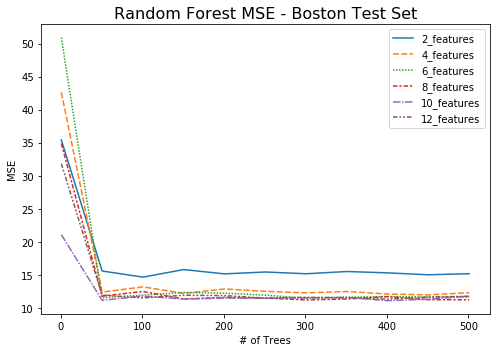

In [5]:
fig, ax = plt.subplots(figsize=(7,5))

sns.lineplot(data=rf_mse_df)
ax.set_title('Random Forest MSE - Boston Test Set', fontsize=16)
ax.set_xlabel('# of Trees')
ax.set_ylabel('MSE')
fig.tight_layout();

The lowest test MSE of **11.072796** was acehieved using **351 estimators** and **6 features**. In general, the models with **>=6 features** performed similary when **>= 51 estimators**. When using 12 features, there seemed to be a bit of overfitting as the MSE increased.

## 8.8. Apply a regression to the Carseats dataset to predict sales.

In [6]:
url_path = os.path.abspath('..')
carseats = pd.read_csv(url_path + '/data/Carseats.csv')

# Feature engineering
carseats['ShelveLoc'] = pd.factorize(carseats['ShelveLoc'])[0]
carseats['Urban'] = carseats['Urban'].map({'No': 0, 'Yes':1})
carseats['US'] = carseats['US'].map({'No': 0, 'Yes': 1})

carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,0,42,17,1,1
1,11.22,111,48,16,260,83,1,65,10,1,1
2,10.06,113,35,10,269,80,2,59,12,1,1
3,7.40,117,100,4,466,97,2,55,14,1,1
4,4.15,141,64,3,340,128,0,38,13,1,0


In [7]:
X = carseats.drop('Sales', axis=1)
y = carseats['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [8]:
dtree_regr = DecisionTreeRegressor(max_depth = 5)
dtree_regr.fit(X_train, y_train)
pred = dtree_regr.predict(X_test)

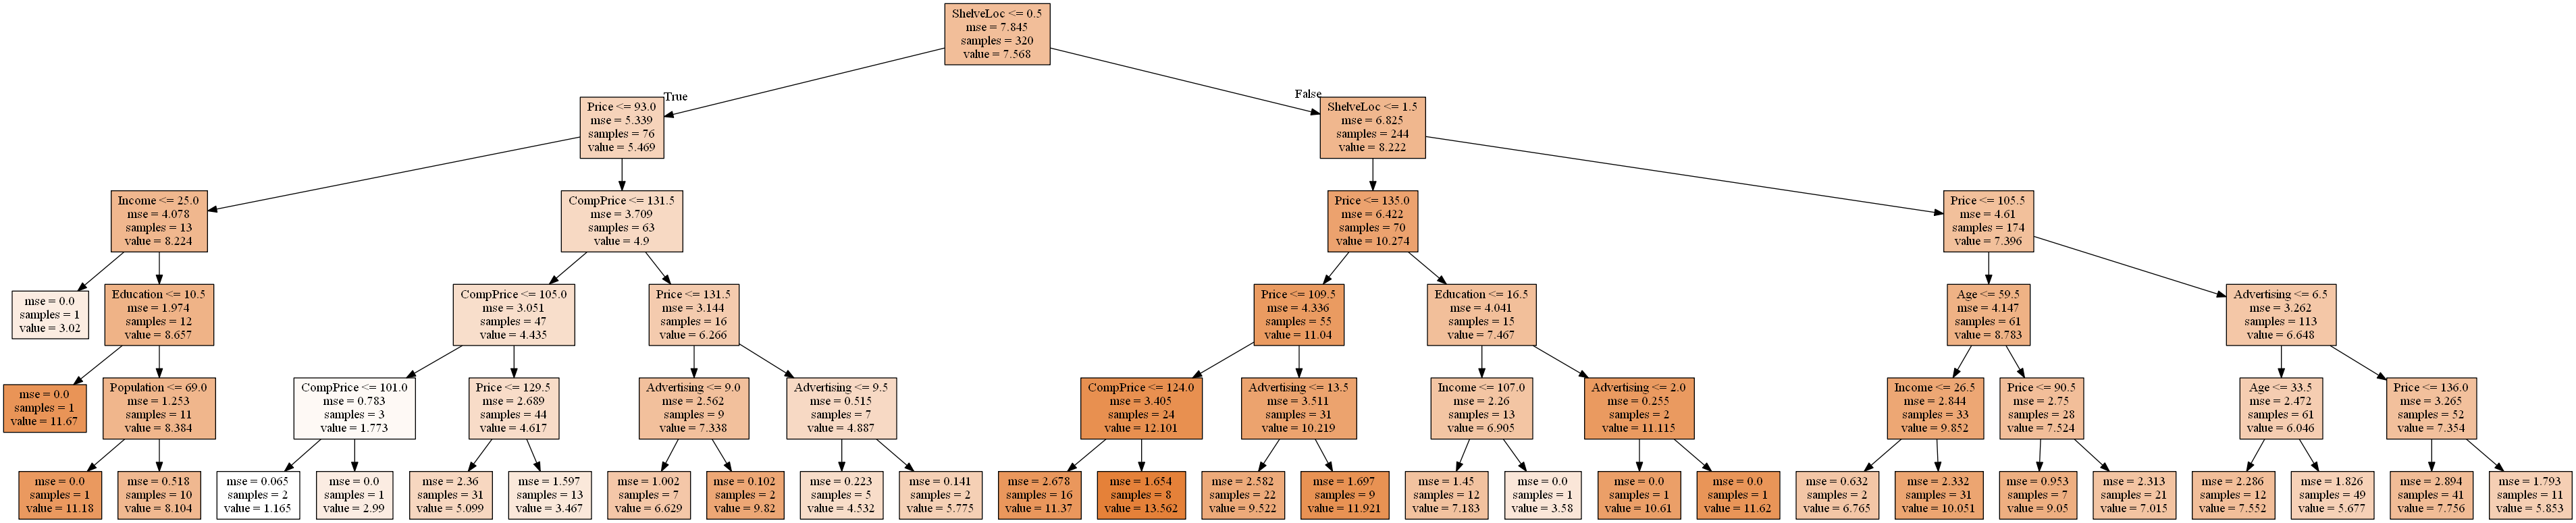

In [9]:
tree_viz, = ch8_utils.print_tree(dtree_regr, X_train.columns, class_names=None, filled=True)
Image(tree_viz.create_png())

In [10]:
print('Decision Tree MSE: {:.4}'.format(mean_squared_error(y_test, pred)))

Decision Tree MSE: 5.776


It seems that the sales of carseats is more influenced by adveristing/marketing than product quality/safety. In general, the better the shelve base, the greater the sales. Also, the more affluent the market/consumer - e.g., income and competitive product price - the greater the sales.

In summary, if a company targets the lower economic class, the less goods it is expected to sell

#### Use cross-validation to determine optimal level of tree complexity.

In [11]:
max_depth_arr = np.arange(1, 11)
avg_train_mse_arr = []
train_cross_val_df = pd.DataFrame()
test_mse_arr = []

for depth in max_depth_arr:
    regr = DecisionTreeRegressor(max_depth=depth)
    regr.fit(X_train, y_train)
    
    # training set metrics
    train_cross_val_arr = -1 * cross_val_score(regr, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    train_cross_val_df[str(depth) + '_depth'] = train_cross_val_arr
    
    train_mse = np.mean(train_cross_val_arr)
    avg_train_mse_arr.append(train_mse)
    
    # test set
    pred = regr.predict(X_test)
    test_mse = mean_squared_error(pred, y_test)
    test_mse_arr.append(test_mse)
    

In [12]:
train_c_val_df, avg_train_mse_arr, test_mse_arr = ch8_utils.calc_train_test_mse_decision_tree_regr(X_train,
                                                                                                X_test,
                                                                                                y_train,
                                                                                                y_test,
                                                                                                10,
                                                                                                10)

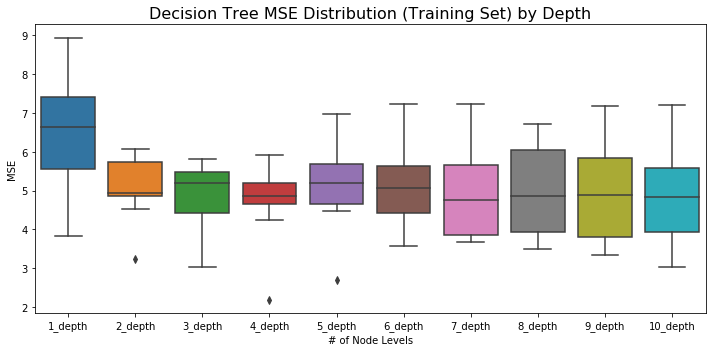

In [13]:
fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(data=train_c_val_df, ax=ax)
ax.set_title('Decision Tree MSE Distribution (Training Set) by Depth', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();

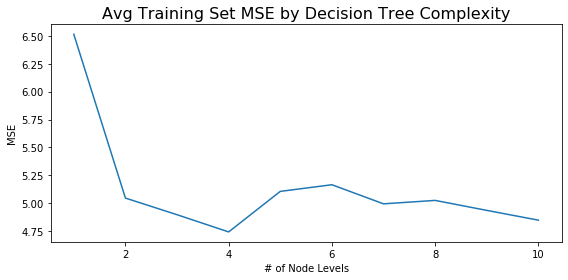

In [14]:
max_depth_arr = np.arange(1, 11)

fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x=max_depth_arr, y=avg_train_mse_arr, ax=ax)
ax.set_title('Avg Training Set MSE by Decision Tree Complexity', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();

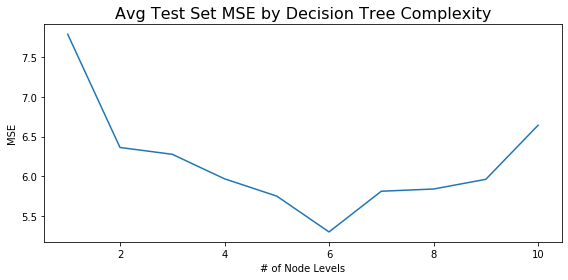

In [15]:
fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x=max_depth_arr, y=test_mse_arr, ax=ax)
ax.set_title('Avg Test Set MSE by Decision Tree Complexity', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();

A depth of 7 produces the optimal MSE of ~5.6, which is lower than allowing the tree to grow.

### 8.4.d. Apply the previous approach to a bagging model.

In [16]:
num_features = X.shape[1]

train_c_val_df, avg_train_mse_arr, test_mse_arr = ch8_utils.calc_train_test_mse_bagging_regr(X_train,
                                                                                            X_test,
                                                                                            y_train,
                                                                                                y_test,
                                                                                                10,
                                                                                                10)

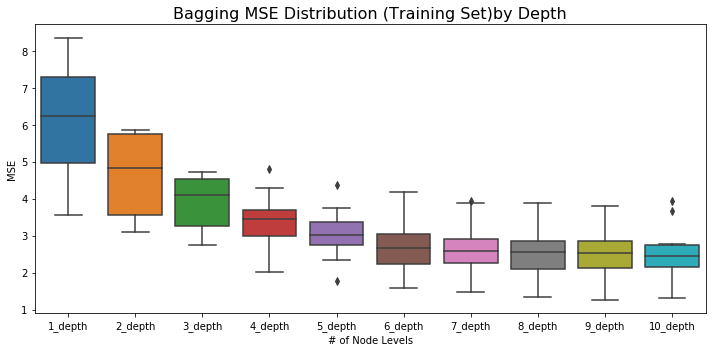

In [17]:
fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(data=train_c_val_df, ax=ax)
ax.set_title('Bagging MSE Distribution (Training Set)by Depth', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();

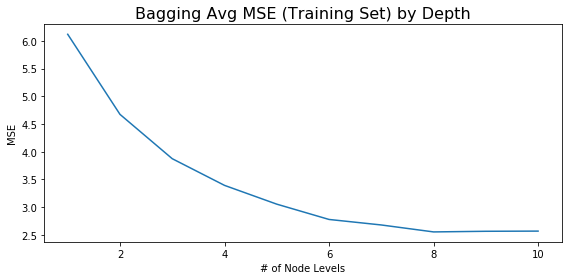

In [18]:
max_depth_arr = np.arange(1, 11)

fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x=max_depth_arr, y=avg_train_mse_arr, ax=ax)
ax.set_title('Bagging Avg MSE (Training Set) by Depth', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();

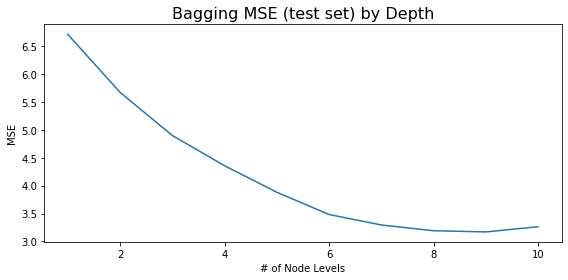

In [19]:
fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x=max_depth_arr, y=test_mse_arr, ax=ax)
ax.set_title('Bagging MSE (test set) by Depth', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();

#### 8.7.d Bagging Feature Importance

In [20]:
bag_regr = RandomForestRegressor(max_depth=7,
                                max_features=X_train.shape[1])
bag_regr.fit(X_train, y_train)

pred = bag_regr.predict(X_test)
test_mse = mean_squared_error(pred, y_test)

In [21]:
feature_importance = pd.DataFrame({'importance': bag_regr.feature_importances_*100}, index=X_train.columns)
feature_importance.sort_values('importance', axis=0, ascending=True, inplace=True)
feature_importance.reset_index()

,index,importance
0,US,0.344656
1,Urban,0.410408
2,Education,2.331040
3,Population,3.080451
4,Income,4.629914
5,Advertising,7.605027
6,CompPrice,9.213945
7,Age,9.788463
8,Price,28.486463
9,ShelveLoc,34.109633


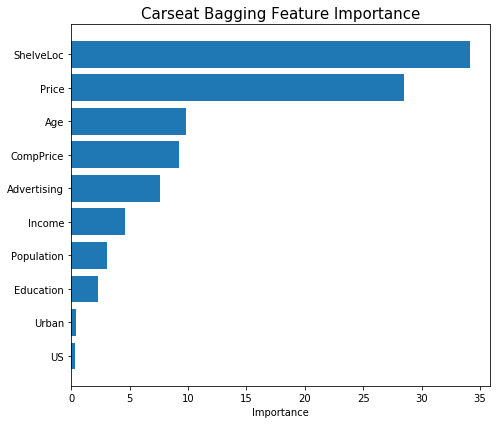

In [22]:
ch8_utils.display_bagging_rf_feature_importance(bag_regr, X_train, 'Carseat Bagging Feature Importance', (7,6))

### 8.8.e Apply Random Forest

In [23]:
# Use GridSearchCV to determine the optimal number of features

rf_regr = RandomForestRegressor()
cv = KFold(n_splits=10, shuffle=True, random_state=3)

# determine optimal number of features per split and depth
grid = dict()
grid['max_features'] = np.arange(2, X_train.shape[0])
grid['max_depth'] = np.arange(1, 7)

gsearch = GridSearchCV(rf_regr, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

results = gsearch.fit(X_train, y_train)

print('Best MSE: {:.5}'.format(results.best_score_))
print('Optimal # of features: {}'.format(results.best_params_['max_features']))
print('Optimal Depth: {}'.format(results.best_params_['max_depth']))

Best MSE: -2.7292
Optimal # of features: 8
Optimal Depth: 6


In [24]:
# Use best parameters to predict carseat sales.
rf_regr = RandomForestRegressor(max_features=8,
                               max_depth=6)

rf_regr.fit(X_train, y_train)
pred = rf_regr.predict(X_test)

print('Test MSE: {:5}'.format(mean_squared_error(y_test, pred)))

Test MSE: 3.4586723017282353


In [25]:
#### Plot the test MSE depending on number of features per split

num_features_arr = np.arange(1, X_train.shape[1])
test_mse_arr = []

for num in num_features_arr:
    rf_regr = RandomForestRegressor(max_features=num)
    rf_regr.fit(X_train, y_train)
    
    pred = rf_regr.predict(X_test)
    
    mse = mean_squared_error(y_test, pred)
    test_mse_arr.append(mse)

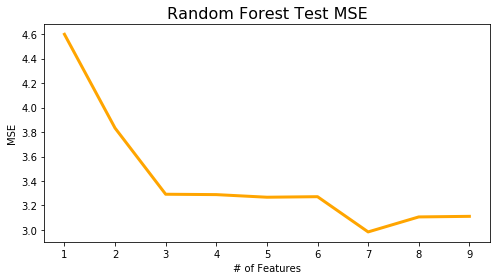

In [26]:
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(num_features_arr, test_mse_arr, c='orange', linewidth=3)
ax.set_title('Random Forest Test MSE', fontsize=16)
ax.set_xlabel('# of Features')
ax.set_ylabel('MSE')

fig.tight_layout();

Overall, the trend of the MSE line slopes downward until it achieves an optimal minimum at **7 fetures**. At which point, MSE begins to increase. I expected such a trend. However, it is odd that there is a spike at 6 features.

In [27]:
url_path = os.path.abspath('..')
carseats = pd.read_csv(url_path + '/data/Carseats.csv')

## 8.9. OJ Dataset

CH = Citrus Hill <-- 1
<br>
MM = Minute Maid <-- 0

Work requires R.

In [28]:
url_path = os.path.abspath('..')
oj = pd.read_csv(url_path + '/data/OJ.csv', index_col=0)
oj.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
1,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
2,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
3,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
4,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
5,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


#### 8.9.a. Create a training set comprised of 800 random observations.

In [29]:
oj['STORE'].unique()

array([1, 0, 2, 3, 4], dtype=int64)

In [30]:
carseats['ShelveLoc'] = pd.factorize(carseats['ShelveLoc'])[0]
carseats['Urban'] = carseats['Urban'].map({'No': 0, 'Yes':1})
carseats['US'] = carseats['US'].map({'No': 0, 'Yes': 1})

In [31]:
oj['oj_brand'] = oj['Purchase'].map({'CH': 1, 'MM': 0})
oj['Store7'] = oj['Store7'].map({'No': 0, 'Yes': 1})

In [32]:
X = oj.drop(['oj_brand', 'Purchase'], axis=1)
y = oj['oj_brand']

prcnt_test = 1 - (800 / oj.shape[0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=prcnt_test, random_state=3)

#### 8.9.b. Fit a decision treee. Produce summary statistics. What is the training error? How many terminal nodes does the tree have?

In [33]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
pred = dtree.predict(X_test)

accuracy = accuracy_score(y_test, pred)

('Acc')

'Acc'

---

# 8.10. Use boosting to predict Salary in the Hitters dataset.

In [34]:
url_path = os.path.abspath('..')
hitters = pd.read_csv(url_path + '/data/Hitters.csv', index_col=0)

hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


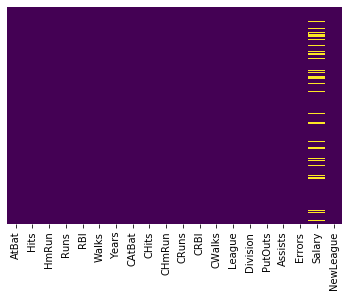

In [35]:
sns.heatmap(hitters.isnull(), cmap='viridis', cbar=False, yticklabels=False);

In [36]:
hitters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322 entries, -Andy Allanson to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    obje

### Remove null values and log-transform the salaries

In [37]:
hitters.dropna(axis=0, inplace=True)
hitters['salary_log10'] = np.log10(hitters['Salary'])
hitters['league_is_american'] = hitters['League'].map({'A': 1, 'N': 0})
hitters['new_league_is_american'] = hitters['NewLeague'].map({'A': 1, 'N': 0})
hitters['division_is_east'] = hitters['Division'].map({'E': 1, 'W':0})

hitters.drop(['Salary', 'League', 'NewLeague', 'Division'], axis=1, inplace=True)

In [38]:
X = hitters.drop('salary_log10', axis=1)
y = hitters['salary_log10']

X_train, X_test = X.iloc[:200, :], X.iloc[200:, :]
y_train, y_test = y.iloc[:200], y.iloc[200:]

In [39]:
X_train

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,league_is_american,new_league_is_american,division_is_east
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,0,0,0
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,1,1,0
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,0,0,1
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,0,0,1
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-Ron Cey,256,70,13,42,36,44,16,7058,1845,312,965,1128,990,41,118,8,0,1,1
-Rob Deer,466,108,33,75,86,72,3,652,142,44,102,109,102,286,8,8,1,1,1
-Rick Dempsey,327,68,13,42,29,45,18,3949,939,78,438,380,466,659,53,7,1,1,1
-Ron Hassey,341,110,9,45,49,46,9,2331,658,50,249,322,274,251,9,4,1,1,1


#### 8.10.c. Perform boosting on the training set w/ 1,000 trees for a range of values of the shrinkage parameter lambda. Produce a plot with different shrinkage values on the x-axis and the corresponding

In [40]:
lambda_rng = [0.001, 0.01, 0.1, 1]
train_mse_arr = []

for lam in lambda_rng:
    g_boost = GradientBoostingRegressor(n_estimators=1000, learning_rate=lam, random_state=3)
    g_boost.fit(X_train, y_train)
    train_pred = g_boost.predict(X_train)
    train_mse_arr.append(mean_squared_error(y_train, train_pred))

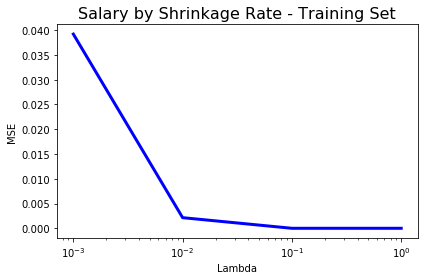

In [41]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(lambda_rng, train_mse_arr, c='b', linewidth=3)
ax.set_xscale('log')
ax.set_title('Salary by Shrinkage Rate - Training Set', fontsize=16)
ax.set_xlabel('Lambda')
ax.set_ylabel('MSE')
fig.tight_layout();

### 8.10.d. Perform the above exercise with the test set.

In [42]:
lambda_rng = [0.001, 0.01, 0.1, 1]
test_mse_arr = []

for lam in lambda_rng:
    g_boost = GradientBoostingRegressor(n_estimators=1000, learning_rate=lam, random_state=3)
    g_boost.fit(X_train, y_train)
    pred = g_boost.predict(X_test)
    test_mse_arr.append(mean_squared_error(y_test, pred))

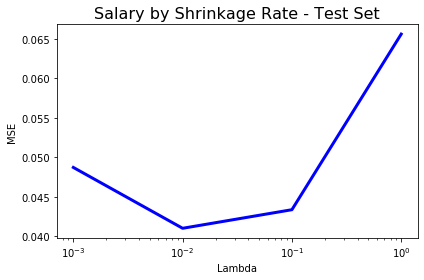

In [43]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(lambda_rng, test_mse_arr, c='b', linewidth=3)
ax.set_xscale('log')
ax.set_title('Salary by Shrinkage Rate - Test Set', fontsize=16)
ax.set_xlabel('Lambda')
ax.set_ylabel('MSE')
fig.tight_layout();

Optimal Gradient Boost Using Training Set Results (for later use)

In [55]:
gboost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, random_state=3)
gboost.fit(X_train, y_train)
pred = gboost.predict(X_test)
mse = mean_squared_error(y_test, pred)

print('Optimal Gradient Boost MSE (test set): {:.6}'.format(mse))

Optimal Gradient Boost MSE (test set): 0.043354


### 8.10.e. Compare Gradient Boost's test MSE with Linear, Ridge, and Lasso Regression

Linear Regression

In [44]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
pred = lin_reg.predict(X_test_scaled)

mse = mean_squared_error(y_test, pred)
print("Linear Regression Test MSE: {:.5}".format(mse))

Linear Regression Test MSE: 0.092758


Ridge Regression

In [45]:
# Alpha is solely used for Ridge Regression
alphas = 10**np.linspace(10,-2,100)*0.5
cv = KFold(n_splits=10, shuffle=True, random_state=3)

In [54]:
ridge_cv = RidgeCV(alphas=alphas, cv=cv, fit_intercept=True, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)

print('Ridge CV Best R-Squared (Train set): {:.7}'.format(ridge_cv.best_score_))
print('Best Alpha: {:.6}'.format(ridge_cv.alpha_))

Ridge CV Best R-Squared (Train set): -0.07499983
Best Alpha: 66.0971


In [52]:
ridge = Ridge(max_iter=1000)
ridge.set_params(alpha=ridge_cv.alpha_)
ridge.fit(X_train_scaled, y_train)
pred = ridge.predict(X_test_scaled)
mse = mean_squared_error(y_test, pred)

print('Ridge MSE (test set): {:.5}'.format(mse))

Ridge MSE (test set): 0.08532


Lasso Regression

In [53]:
lasso_cv = LassoCV(alphas=None, cv=cv, fit_intercept=True)
lasso_cv.fit(X_train_scaled, y_train)

#print('Lasso CV Best R-Squared (train set): {:.7}'.format(lasso_cv.best_score_))
print('Best Alpha: {:.7}'.format(lasso_cv.alpha_))

Best Alpha: 0.001899609


In [51]:
lasso = Lasso(max_iter=1000)
lasso.set_params(alpha=lasso_cv.alpha_)
lasso.fit(X_train_scaled, y_train)
pred = lasso.predict(X_test_scaled)

print('Lasso MSE (test set): {:.5}'.format(mean_squared_error(y_test, pred)))

Lasso MSE (test set): 0.088574


#### 8.10.f. Which variables appear to be the most important predictors in the boosted model?

In [58]:
salary_boost_results = permutation_importance(gboost, X_test, y_test, n_repeats=10, random_state=3, n_jobs=-1)
perm_importance = pd.DataFrame({'importance': salary_boost_results.importances_mean*100}, index=X_test.columns)
perm_importance.sort_values('importance', axis=0, ascending=True, inplace=True)

In [71]:
sorted_idx = salary_boost_results.importances_mean.argsort()
perm_importance_2 = pd.DataFrame(salary_boost_results.importances.T *100, columns = X_test.columns)

In [80]:
sorted_idx = perm_importance_2.median().sort_values().index[::-1]
perm_import_sorted = perm_importance_2[sorted_idx]

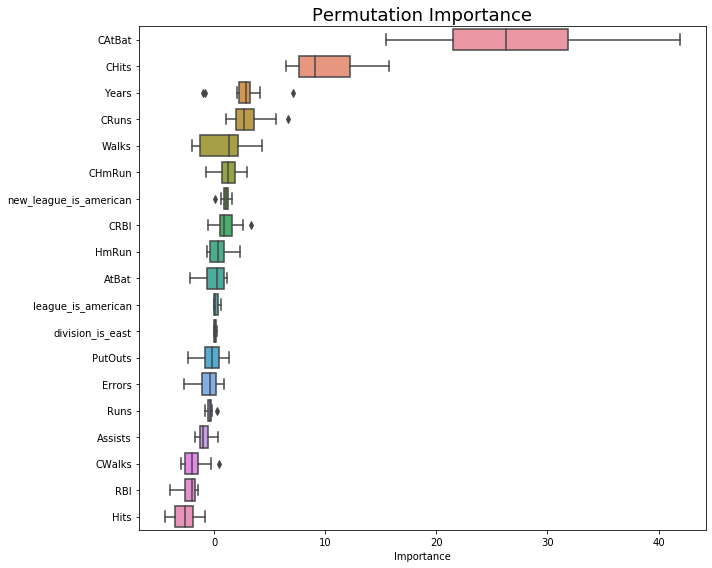

In [83]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=perm_import_sorted, orient='h', ax=ax)
ax.set_xlabel('Importance')
ax.set_title('Permutation Importance', fontsize=18)
fig.tight_layout();

The two most important predictors are a player's number of career at-bats (CAtBat) and the number of career hits (CHits).

#### 8.10.g. Now apply bagging to the training set. What is the best test MSE for this approach?